In [2]:
import os
import sys
from glob import glob

import rasterio as rio

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from subprocess import Popen

import numpy as np

import warnings

import pandas as pd

from sklearn import metrics, exceptions

%matplotlib inline

# Fig X: Colorado Model Comparision

We're going to produce a comparison of SCA data products for a single Planet Labs Inc scene in Colorado. The comparisons are CubeSat ML SCA, Sentinel 2 NDSI, and Landsat 8 fSCA. 

In [3]:
root = "/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip"

In [4]:
!ls {root}

20180524_172637_0f2d_3B_AnalyticMS_SR_clip.tif
aso_metrics.json
bbox-index.json
comparator
data-mask-simple.geojson
data-mask.geojson
data-mask.json
data-mask.kml
data-mask.zip
ls8
mask
pred_index.dbf
pred_index.prj
pred_index.shp
pred_index.shx
pred_index.zip
preds
sentinel-2


In [5]:
comparator_dir = "comparator"

In [6]:
comparators = [
    "*clip_merged.tif", # ML Predictions
    "NDSI-clipped.tif", # Sentinel 2 NDSI (thresholded)
    "*SNOW_4326_05.tif"      # LS8 fSCA (thresholded)
]

In [7]:
ASO = glob(os.path.join(root, comparator_dir, "*binary_merged.tif"))[0]
print(ASO)

/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/comparator/ASO_3M_SD_USCOGE_20180524_binary_merged.tif


In [8]:
comparator_files = [glob(os.path.join(root, comparator_dir, c))[0] for c in comparators]
print(comparator_files)

['/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/comparator/20180524_172637_0f2d_3B_AnalyticMS_SR_clip_merged.tif', '/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/comparator/NDSI-clipped.tif', '/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/comparator/LC08_CU_010009_20180526_20190615_C01_V01_SNOW_4326_05.tif']


## Coarsen ASO to comparator resolution

In [9]:
def coarsen(asoPath, comparatorPath, outdir=None):
    """
    Creates a virtual raster with ASO and comparator stacked (aso band 1).
    
    Uses data_region.geojson in the ASO directory to clip the VRT. 
    """
    

    
    gdalCmd = "source activate qgis && "\
              'gdalbuildvrt -overwrite -resolution lowest -separate -r nearest -vrtnodata "-9999 -9999" {output}.vrt {aso} {comparator} && '\
              "gdalwarp -overwrite -cutline {cutline} -crop_to_cutline -dstnodata -9999 {output}.vrt {output}_clipped.vrt "
    
    if outdir is None:
        outdir = os.path.join(os.path.dirname(asoPath), "coarsened")
        os.makedirs(outdir, exist_ok=True)
        

    comparatorOutfileRoot = os.path.join(outdir, "ASO_vs_"+os.path.splitext(os.path.basename(comparatorPath))[0])
    cutlinePath = glob(os.path.join(os.path.dirname(asoPath), "data*.geojson"))[0]
    
    _cmd = gdalCmd.format(aso = asoPath, comparator = comparatorPath, output = comparatorOutfileRoot, cutline=cutlinePath)
    Popen(_cmd, shell=True).communicate()
    
    return(os.path.join(outdir, comparatorOutfileRoot+"_clipped.vrt"))

In [10]:
coarsened_comparators = [coarsen(ASO, comparator) for comparator in comparator_files]

## Compute Performance Metrics

In [11]:
def compute_performance(true, pred, nodata=-9999):
    
    mask = true.mask
    true = true.data[~mask]

    pred = pred.data[~mask]
    
    if len(np.unique(true)) != len(np.unique(pred)):
        if len(np.unique(true)) > len(np.unique(pred)):
            true[true == nodata] = 0
        else:
            pred[pred == nodata] = 0

    assert(pred.shape == true.shape)

    print (np.unique(true), np.unique(pred))
    
    with warnings.catch_warnings():
        warnings.filterwarnings('error')

        try: 
            performance = metrics.precision_recall_fscore_support(true, pred, average = 'binary')

            accuracy = metrics.balanced_accuracy_score(true, pred)

            kappa = metrics.cohen_kappa_score(true, pred)
        except exceptions.UndefinedMetricWarning:
            print("One or more metrics Undefined. Skipping.")
            return None

    result = {
        "Precision": performance[0],
        "Recall" : performance[1],
        "F-Score": performance[2],
        "Balanced Accuracy": accuracy,
        "Kappa" : kappa
    }

    return result

In [12]:
coarsened_comparators

['/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/comparator/coarsened/ASO_vs_20180524_172637_0f2d_3B_AnalyticMS_SR_clip_merged_clipped.vrt',
 '/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/comparator/coarsened/ASO_vs_NDSI-clipped_clipped.vrt',
 '/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/comparator/coarsened/ASO_vs_LC08_CU_010009_20180526_20190615_C01_V01_SNOW_4326_05_clipped.vrt']

In [13]:
perf_metrics = []

for comparison in coarsened_comparators:
    # e.g. ASO_vs_<ndsi/ls8/etc>.tif, get comparison type
    compared_to = os.path.splitext(os.path.basename(comparison))[0].split("_vs_")[1]
    this_comparison = rio.open(comparison)
    perf_metrics.append(pd.DataFrame.from_dict({
        compared_to : compute_performance(
                        this_comparison.read(1, masked=True),
                        this_comparison.read(2, masked=True))
    }, orient='index'))

[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]


In [14]:
all_results = pd.concat(perf_metrics)

In [15]:
preds = all_results[all_results.index.str.contains("AnalyticMS")]
s2 = all_results[all_results.index.str.contains("NDSI")]
ls8 = all_results[all_results.index.str.contains("SNOW")]

In [16]:
preds = preds.reset_index(drop=True)
preds["SCA"] = "CubeSat ML"

s2 = s2.reset_index(drop=True)
s2["SCA"] = "Sentinel 2 NDSI"

ls8 = ls8.reset_index(drop=True)
ls8["SCA"] = "Landsat 8 fSCA"

In [17]:
all_reshaped = pd.concat([preds, s2, ls8])

In [18]:
melted = pd.melt(all_reshaped.reset_index(), id_vars='SCA')

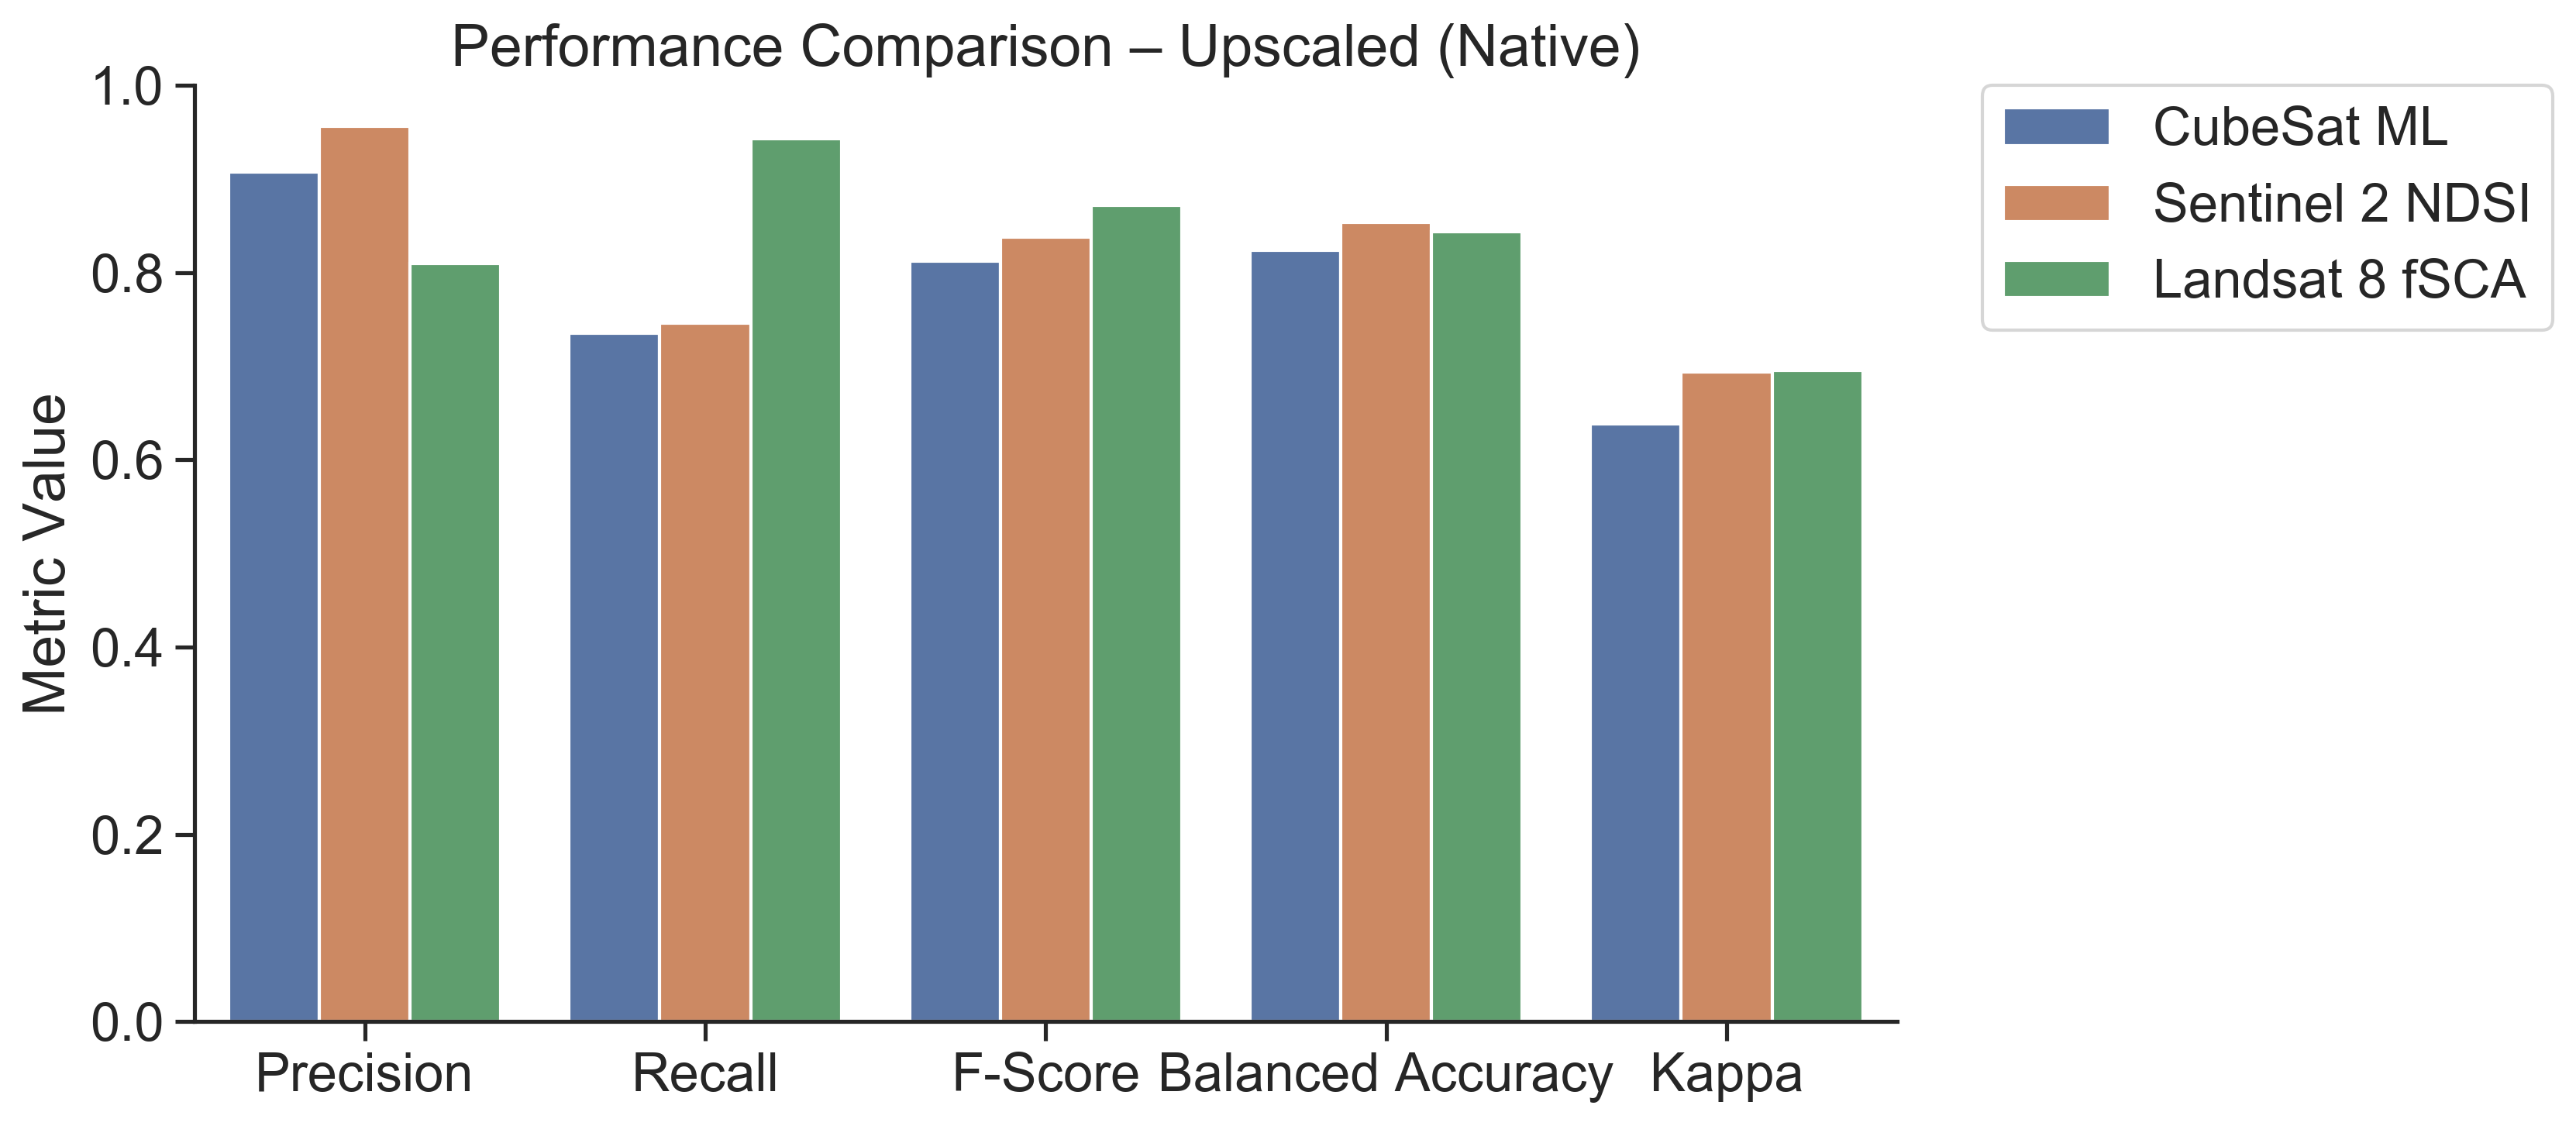

In [20]:

sns.set(style='ticks', font_scale=1.5)

fig, ax = plt.subplots(figsize=(11.5,5), dpi=300)
bp = sns.barplot(x='variable', hue='SCA', y = 'value', data=melted, ax= ax, order=['Precision', "Recall", "F-Score", "Balanced Accuracy", "Kappa"])
plt.ylim([0, 1])
plt.xlabel("")
plt.ylabel("Metric Value")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.tight_layout()
plt.title("Performance Comparison – Upscaled (Native)")
plt.savefig("performance.png", dpi=300, bbox_inches='tight')


# test_results = add_stat_annotation(ax, data=melted2, x='variable', y='value', hue='SCA',
#                                    box_pairs=box_pairs,
#                                    test='t-test_ind', text_format='star',
#                                    loc='outside', verbose=2)
# plt.savefig("tuol-sentinel-ml-performance_sig.png", dpi=300, bbox_inches='tight')

In [22]:
melted.to_csv(os.path.join(root, comparator_dir, "all_metrics.csv"))